# Setup

In [ ]:
from SLM_Hamamatsu_X13138 import HamaSLM_13138
from SLM_Hamamatsu_X15213 import HamaSLM_15213
from new_slm_method import slm_monitor
from slm import SlmDisplay
from PIL import Image
import matplotlib.pyplot as plt
import Phases as ph
import os
import numpy as np
from PIL import Image
import time
import ising_machine

In [23]:
def center_overlay_add_crop(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Overlays array ``a`` centered onto array ``b``.
s
    Parameters
    ----------
    a : np.ndarray
        The array to be overlaid, should not be larger than `b`.
    b : np.ndarray
        The base array where `a` will be overlaid.

    Returns
    -------
    np.ndarray
        The array ``b`` with ``a`` overlaid and added at the center. Where at the
        rest of the elements we put 0.

    Examples
    --------
    >>> a = np.ones((2, 2))
    >>> b = np.ones((4, 4))*2
    >>> center_overlay_add_crop(a, b)
    array([[0, 0, 0, 0],
        [0, 3, 3, 0],
        [0, 3, 3, 0],
        [0, 0, 0, 0]])
    """
    ax, ay = a.shape
    bx, by = b.shape
    if ax > bx or ay > by:
        # ax,ay = b.shape
        # bx,by = a.shape
        raise ValueError(f"Cannot overlay: 'a' is larger than 'b'. {a.shape} > {b.shape}")

    x0 = (bx - ax) // 2
    y0 = (by - ay) // 2

    out = np.zeros(b.shape)
    out[x0 : x0 + ax, y0 : y0 + ay] = a + b.copy()[x0 : x0 + ax, y0 : y0 + ay]
    return out

# SLM - Connection

Select the Correction Pattern and the modulation depth

In [107]:
# filename = r'\correction_patterns_13138\CAL_LSH0802650_810nm.bmp'
filename = r'\correction_patterns_15213\CAL_LSH0805025_810nm.bmp'


current_path = os.getcwd()  # + r"\slm"
filepath = current_path + filename
correction_pattern = Image.open(filepath)
correction_pattern = np.asarray(correction_pattern, dtype=np.int64)
modulation_depth = 163
# plt.imshow(correction_pattern, 'gray')



In [108]:
from cffi import FFI
import time
import os

# Communicate with hamamatsu slm
class HamaSLM():
    def __init__(self):
       # super(SlmDisplay, self).__init__()
        """ slm init variables"""
        self.current_path = os.getcwd()  # + r"\slm"
        SLM_DLL_FOLDER = self.current_path + r"\hpkSLMdaLV_stdcall_64bit"
        os.environ['PATH'] = SLM_DLL_FOLDER + os.pathsep + os.environ.get('PATH', '')
        os.add_dll_directory(self.current_path + r"\hpkSLMdaLV_stdcall_64bit")

        self.ffi = FFI()
        self.cdef_from_file = None
        self.header = None
        self.slmffi = None
        self.bID = []
        self.bIDmem = []

    def connect(self) -> int:
        """opens communication with the slm

        Returns
        -------
        int & sets upon self
            writes bID to the class variables and returns it as a string
        """
        self.header = self.current_path + r"\hpkSLMdaLV_stdcall_64bit\hpkSLMdaLVt.h"
        self.slmffi = self.ffi.dlopen(self.current_path + r"\hpkSLMdaLV_stdcall_64bit\hpkSLMdaLV.dll")
        try:
            with open(self.header) as slm_header:
                self.cdef_from_file = slm_header.read()

        except FileNotFoundError:
            print("header not found")
        except IOError:
            print("could not open header")
        finally:
            if self.cdef_from_file == '':
                print('empty header')

        self.ffi.cdef(self.cdef_from_file, override=True)
        bIDList = self.ffi.new('uint8_t[10]')
        try:
            self.slmffi.Open_Dev(bIDList, 10)
            print('SLM init: com ok')
        except:
            print('slm init: no communication')
        self.bID = bIDList[0]
        self.bIDmem = bIDList
        return self.bID

    def close_slm(self) -> bool:
        """closes communication with the slm
        """
        try:
            self.slmffi.Close_Dev(self.bIDmem, 10)
            self.ffi.dlclose(self.slmffi)
            closed = True
            print('close SLM: ok')
        except ValueError:
            closed = True
            print('SLM already closed')
                
        except:
            print('close com with slm failed')
            closed = False


        return closed
    

    def check_temp(self) :
        """reads slm head & board temp"""


        self.bID = self.ffi.cast('uint8_t', self.bID)
        HeadTemp = self.ffi.new('double *')
        CBTemp = self.ffi.new('double *')
        self.slmffi.Check_Temp(self.bID, HeadTemp, CBTemp)
        result = {'Head_Temperature': HeadTemp[0],'Driver_Temperature': CBTemp[0] }
        return result


    def upload_phase(self, image) -> None:
        """uploads uint8 phase to lcos

        Returns
        -------
        not a single thing
        """
        image = image.astype('uint8')
        ArraySize = self.ffi.new('int32_t*')
        ArraySize = self.ffi.cast('int32_t', image.shape[1] * image.shape[0])
        XPixel = self.ffi.new('uint32_t*')
        XPixel = self.ffi.cast('uint32_t', image.shape[1])
        YPixel = self.ffi.new('uint32_t*')
        YPixel = self.ffi.cast('uint32_t', image.shape[0])
        SlotNo = self.ffi.new('uint32_t*')
        SlotNo = self.ffi.cast('uint32_t', 0)
        ArrayIn = self.ffi.new('uint8_t [{}]'.format(image.shape[1] * image.shape[0]))
        # 2D 2 1D
        image = image.flatten()
        for i, el in enumerate(ArrayIn):
            ArrayIn[i] = self.ffi.cast('uint8_t', image[i])
        bID = self.ffi.cast('uint8_t', self.bID)
        """upload, the func itself"""
        self.slmffi.Write_FMemArray(bID, ArrayIn, ArraySize, XPixel, YPixel, SlotNo)
        time.sleep(0.1)  # fixme: can this be reduced?
        # print(("Upload"))
        # print("uploaded")

    def get_Size(self):
        return 1272,1024
    
    def __del__(self):
        print('SLM dead')



Establish connection

In [109]:
slm_class = HamaSLM()

In [110]:
slm_class.connect()

SLM init: com ok


6

In [112]:
slm_control = SlmDisplay(slm_class=slm_class,modulation_depth=modulation_depth,correction_pattern_file=filepath)

(1024, 1272)


In [113]:
slm_class.check_temp()

{'Head_Temperature': 28.4375, 'Driver_Temperature': 54.13845214843752}

Create and Upload Grating Phase - Full Focused Beam

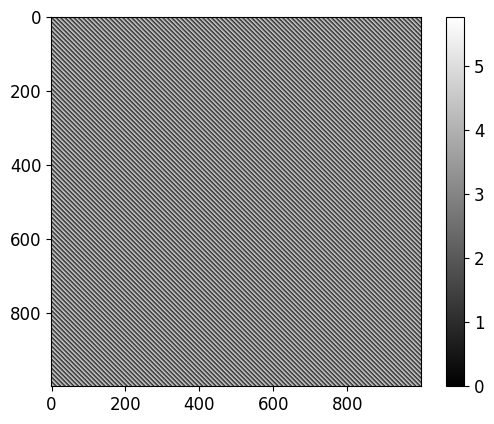

In [169]:
slm_shape = (1024,1024)

grating_phase = ph.grating_steps(slm_shape, 150,150,'x-y', flip=True) # 150 , 150 for spot fiber
grating_phase = grating_phase[12:-12,12:-12]
slm_shape = grating_phase.shape
plt.imshow(grating_phase,'gray')
plt.colorbar()
phi_loaded = slm_control.load_phase([grating_phase])



# Z_2 Mask 

Select the number of steps

In [141]:
steps = 10
z2_phase_mask = np.zeros(grating_phase.shape)
half_i = int(z2_phase_mask.shape[0]//2)
phase_steps = np.linspace(0,2*np.pi,steps)
data = []


For loop to display the phases on the slm

In [142]:
for phii in phase_steps:
    z2_phase_mask = np.zeros(grating_phase.shape)
    z2_phase_mask[:,:half_i] = phii
    phas = slm_control.load_phase([grating_phase,  z2_phase_mask])


if you want to change the phases one by one of the half screen

In [118]:
n = 0
for phh in phase_steps:
    print(f'Index: {n}, Phase: {phh}')
    n+=1

Index: 0, Phase: 0.0
Index: 1, Phase: 1.5707963267948966
Index: 2, Phase: 3.141592653589793
Index: 3, Phase: 4.71238898038469
Index: 4, Phase: 6.283185307179586


Select the number

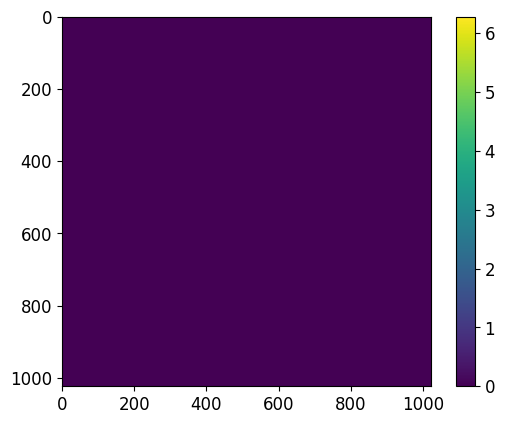

In [147]:
i = 0
z2_phase_mask = np.zeros(grating_phase.shape)
z2_phase_mask[:,:half_i] = phase_steps[i]

plt.imshow(z2_phase_mask,vmax=2*np.pi)
plt.colorbar()

Upload

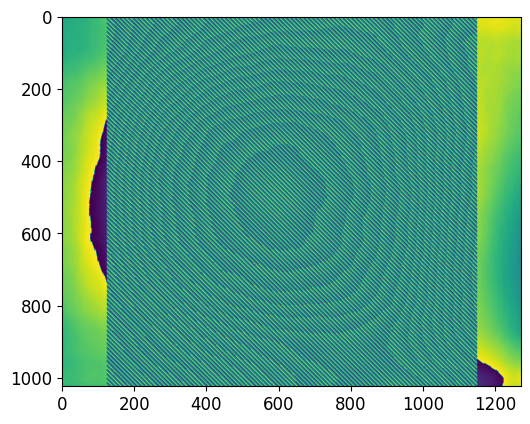

In [148]:
phas = slm_control.load_phase([grating_phase, z2_phase_mask])
plt.imshow(phas)

In [40]:
from other_functions import *

In [41]:
def z2_mask_scan(detector, slm, grating_phase, detector_type = 'camera', steps = 50, data_save = True, direction = 'x'):
    """
    Function to scan the z2 mask with detector
    """
    z2_phase_mask = np.zeros(grating_phase.shape)
    half_i = int(z2_phase_mask.shape[0]//2)
    phase_steps = np.linspace(0,2*np.pi,steps)
    data = []

    if detector_type == 'camera':

        if direction == 'x':
            for phii in phase_steps:
                # print(phii/np.pi)
                z2_phase_mask[:,:half_i] = phii
                slm.load_phase([grating_phase,  z2_phase_mask])
                data.append(detector.take_image())
        else:
            for phii in phase_steps:
                # print(phii/np.pi)
                z2_phase_mask[:half_i,:] = phii
                slm.load_phase([grating_phase,  z2_phase_mask])
                data.append(detector.take_image())
    else:

        if direction == 'x':
            for phii in phase_steps:
                # print(phii/np.pi)
                z2_phase_mask[:,:half_i] = phii
                slm.load_phase([grating_phase,  z2_phase_mask])
                data.append(detector.mean_measure())
        else:
            for phii in phase_steps:
                # print(phii/np.pi)
                z2_phase_mask[:half_i,:] = phii
                slm.load_phase([grating_phase,  z2_phase_mask])
                data.append(detector.mean_measure())

    return np.array(data), phase_steps

In [42]:
def z2_mask_scan_with_noise(detector, slm, grating_phase, detector_type = 'camera', steps = 50, statistics = 100, data_save = True, direction = 'x'):
    """
    Function to scan the z2 mask with detector
    """
    z2_phase_mask = np.zeros(grating_phase.shape)
    half_i = int(z2_phase_mask.shape[0]//2)
    phase_steps = np.linspace(0,2*np.pi,steps)
    data = []
    data_error = []


    if detector_type == 'camera':

        if direction == 'x':
            for phii in phase_steps:
                # print(phii/np.pi)
                z2_phase_mask[:,:half_i] = phii
                slm.load_phase([grating_phase,  z2_phase_mask])
                data.append(detector.take_image())
        else:
            for phii in phase_steps:
                # print(phii/np.pi)
                z2_phase_mask[:half_i,:] = phii
                slm.load_phase([grating_phase,  z2_phase_mask])
                data.append(detector.take_image())
    else:

        if direction == 'x':
            for phii in phase_steps:
                # print(phii/np.pi)
                z2_phase_mask[:,:half_i] = phii
                slm.load_phase([grating_phase,  z2_phase_mask])
                dat = []
                for stat in range(statistics):
                    dat.append(detector.measure_ascii())

                data.append(np.mean(dat))
                data_error.append(np.std(dat))
        else:
            for phii in phase_steps:
                # print(phii/np.pi)
                z2_phase_mask[:half_i,:] = phii
                slm.load_phase([grating_phase,  z2_phase_mask])
                dat = []
                for stat in range(statistics):
                    dat.append(detector.measure_ascii())

                data.append(np.mean(dat))
                data_error.append(np.std(dat))

    return np.array(data), np.array(data_error),phase_steps

# Z_4 Mask - Simple Version

Select the number of steps

In [89]:
steps = 40
z4_phase_mask = np.zeros(grating_phase.shape)
half_i = int(z4_phase_mask.shape[0]//2)
phase_steps = np.linspace(0,2*np.pi,steps)
data = []


For loop to display the phases on the slm

In [90]:
for phii in phase_steps:
    z4_phase_mask[:half_i,:half_i] = phii
    z4_phase_mask[half_i:,half_i:] = phii
    phas = slm_control.load_phase([grating_phase,  z4_phase_mask])


if you want to change the phases one by one of the half screen

In [91]:
n = 0
for phh in phase_steps:
    print(f'Index: {n}, Phase: {phh}')
    n+=1

Index: 0, Phase: 0.0
Index: 1, Phase: 0.16110731556870733
Index: 2, Phase: 0.32221463113741466
Index: 3, Phase: 0.483321946706122
Index: 4, Phase: 0.6444292622748293
Index: 5, Phase: 0.8055365778435366
Index: 6, Phase: 0.966643893412244
Index: 7, Phase: 1.1277512089809514
Index: 8, Phase: 1.2888585245496587
Index: 9, Phase: 1.449965840118366
Index: 10, Phase: 1.6110731556870732
Index: 11, Phase: 1.7721804712557807
Index: 12, Phase: 1.933287786824488
Index: 13, Phase: 2.0943951023931953
Index: 14, Phase: 2.2555024179619028
Index: 15, Phase: 2.41660973353061
Index: 16, Phase: 2.5777170490993173
Index: 17, Phase: 2.738824364668025
Index: 18, Phase: 2.899931680236732
Index: 19, Phase: 3.0610389958054394
Index: 20, Phase: 3.2221463113741464
Index: 21, Phase: 3.383253626942854
Index: 22, Phase: 3.5443609425115614
Index: 23, Phase: 3.7054682580802685
Index: 24, Phase: 3.866575573648976
Index: 25, Phase: 4.027682889217683
Index: 26, Phase: 4.1887902047863905
Index: 27, Phase: 4.349897520355098

Select the number

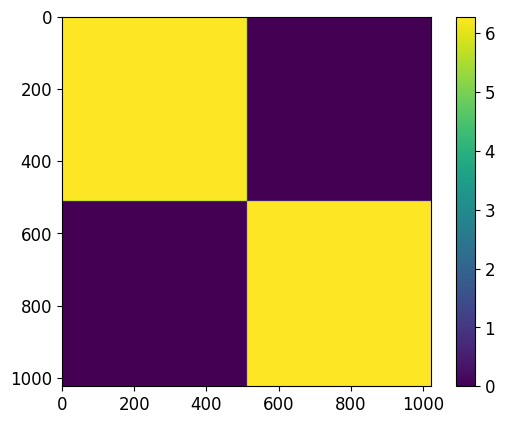

In [97]:
i = 39
z4_phase_mask[:half_i,:half_i] = phase_steps[i]
z4_phase_mask[half_i:,half_i:] = phase_steps[i]

plt.imshow(z4_phase_mask,vmax=2*np.pi)
plt.colorbar()

Upload

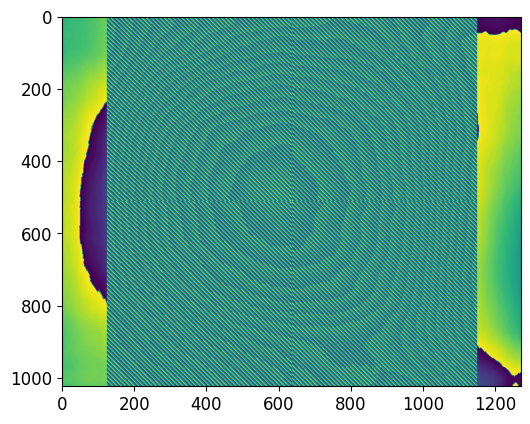

In [96]:
phas = slm_control.load_phase([grating_phase,  z4_phase_mask])
plt.imshow(phas)

In [48]:
from other_functions import *

In [49]:
def z4_mask_scan(detector, slm, grating_phase, detector_type = 'camera', steps = 50, data_save = True, direction = 'x'):
    """
    Function to scan the z4 mask with detector (photodiode or camera)
    """
    z4_phase_mask = np.zeros(grating_phase.shape)
    half_i = int(z4_phase_mask.shape[0]//2)
    z4_phase_mask[:half_i,:half_i] = np.pi/2
    z4_phase_mask[half_i:,:half_i] = np.pi
    z4_phase_mask[:half_i,half_i:] = 0
    z4_phase_mask[half_i:,half_i:] = 3*np.pi/2

    phase_steps = np.linspace(0,4,steps)
    z4_masks = []
    data = []

    if detector_type == 'camera':

        for phii in phase_steps:
            rotated_z4_mask = z4_phase_mask*phii*np.ones(grating_phase.shape)
            slm.load_phase([grating_phase,  rotated_z4_mask])
            z4_masks.append(rotated_z4_mask)
            data.append(detector.take_image())
    
    else:

        for phii in phase_steps:
            rotated_z4_mask = z4_phase_mask*phii*np.ones(grating_phase.shape)
            slm.load_phase([grating_phase,  rotated_z4_mask])
            z4_masks.append(rotated_z4_mask)
            data.append(detector.mean_measure())

    return np.array(data), phase_steps

# Convergence Phases

In [160]:
def upscale(array: np.ndarray, factor: int | tuple[int, int]) -> np.ndarray:
    """
    Upscales a 2D numpy array by a specified factor along each axis.

    This function repeats the elements of a 2D numpy array along its rows and
    columns by a specified factor. If the factor is an integer, it scales both
    dimensions by the same factor. If the factor is a tuple of two integers,
    the first integer scales the rows, and the second scales the columns.

    Parameters
    ----------
    array : np.ndarray
        The 2D numpy array to be upscaled.
    factor : int or tuple[int, int]
        The factor or factors by which to upscale `array`. If an integer is
        provided, both dimensions are scaled by this factor. If a tuple of two
        integers is provided, each integer scales a different dimension.

    Examples
    --------
    Upscale a 2D array by a factor of 2:

    >>> arr = np.array([[1, 2], [3, 4]])
    >>> upscale(arr, 2)
    array([[1, 1, 2, 2],
           [1, 1, 2, 2],
           [3, 3, 4, 4],
           [3, 3, 4, 4]])

    Upscale a 2D array by different factors for rows and columns:

    >>> upscale(arr, (2, 3))
    array([[1, 1, 1, 2, 2, 2],
           [1, 1, 1, 2, 2, 2],
           [3, 3, 3, 4, 4, 4],
           [3, 3, 3, 4, 4, 4]])
    """
    if array.ndim != 2:
        raise ValueError("The input array must be a 2D numpy array.")

    if isinstance(factor, int):
        fact1, fact2 = factor, factor
    else:
        fact1, fact2 = factor
    if fact1 < 0 or fact2 < 0:
        raise ValueError("The upscale factor must be non negative.")

    return array.repeat(fact1, axis=0).repeat(fact2, axis=1)


In [170]:
num_phases = 10 # Number of Spin configurations to be generated from random to polarized spins
n_spins = 100 # Number of Spins
L_spins = int(np.sqrt(n_spins)) # Lattice side size
spin_phases =  []
for w in np.linspace(0, 0.5, num=num_phases):
    spins = np.random.choice([-1, 1], n_spins , p=[w, 1 - w])
    spin_phases.append(spins)

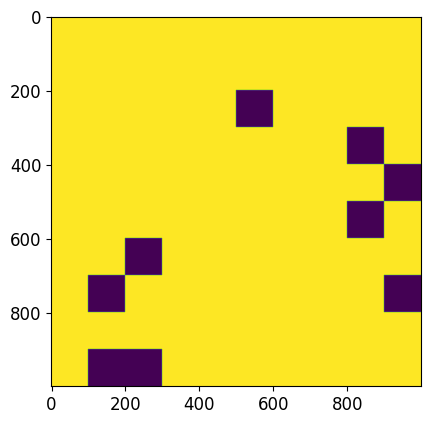

In [171]:
idx = 1
spin_phase = upscale(spin_phases[idx].reshape(L_spins,L_spins),slm_shape[0]//L_spins) # upscale to the correct slm size
plt.imshow(spin_phase)

In [172]:
grating_phase.shape, spin_phase.shape

((1000, 1000), (1000, 1000))

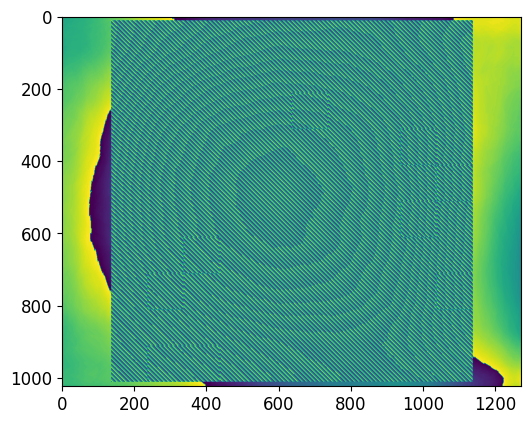

In [173]:
phas = slm_control.load_phase([grating_phase,  spin_phase])
plt.imshow(phas)